# Testing spatial frequency component

In [1]:
import numpy as np
np.set_printoptions(precision=5, suppress=True)
import pylab
import matplotlib.pyplot as plt
%matplotlib inline
#!rm -fr ../files/radial*

In [2]:
import MotionClouds as mc
import os
fx, fy, ft = mc.get_grids(mc.N_X, mc.N_Y, mc.N_frame)
help(mc.envelope_radial)

Help on function envelope_radial in module MotionClouds:

envelope_radial(fx, fy, ft, sf_0=0.125, B_sf=0.1, ft_0=inf, loggabor=True)
    Returns the radial frequency envelope:
    
    Selects a preferred spatial frequency ``sf_0`` and a bandwidth ``B_sf``.
    
    Run the 'test_radial' notebook to see the explore the effect of ``sf_0`` and ``B_sf``, see
    https://neuralensemble.github.io/MotionClouds/posts/testing-radial.html



In [3]:
name = 'radial'
#initialize
fx, fy, ft = mc.get_grids(mc.N_X, mc.N_Y, mc.N_frame)

mc.figures_MC(fx, fy, ft, name)
verbose = False
mc.in_show_video(name)

In [4]:
N = 5
np.logspace(-5, 0., 7, base=2)

array([ 0.03125,  0.05568,  0.09921,  0.17678,  0.31498,  0.56123,  1.     ])

## exploring different frequency bandwidths

In [5]:
for B_sf in np.logspace(-4, 0., N, base=2):
    name_ = name + '-B_sf-' + str(B_sf).replace('.', '_')
    mc.figures_MC(fx, fy, ft, name_, B_sf=B_sf, verbose=verbose)
    mc.in_show_video(name_)

## exploring different (median) central frequencies

In [6]:
for sf_0 in [0.01, 0.05, 0.1, 0.2, 0.4, 0.8]:
    name_ = name + '-sf_0-' + str(sf_0).replace('.', '_')
    mc.figures_MC(fx, fy, ft, name_, sf_0=sf_0, verbose=verbose)
    mc.in_show_video(name_)

Note that some information is lost in the last case as $f_0$ exceeds the Nyquist frequency.

## exploring different speed bandwidths

In [7]:
for B_V in [0, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0]:
    name_ = name + '-B_V-' + str(B_V).replace('.', '_')
    mc.figures_MC(fx, fy, ft, name_, B_V=B_V, verbose=verbose)
    mc.in_show_video(name_)

## Testing without using a log-normal distribution

In [8]:
for B_sf in np.logspace(-4, 0., N, base=2):
    name_ = name + '-B_sf_nologgabor-' + str(B_sf).replace('.', '_')
    mc.figures_MC(fx, fy, ft, name_, B_sf=B_sf, loggabor=False, verbose=verbose)
    mc.in_show_video(name_)    

## checking that sf_0 is consistant with the number of cycles per period

By design, MotionClouds are created to be characterized by a given frequency range. Let's check on the raw image that this is correct.

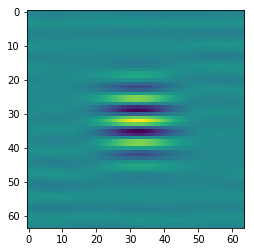

In [9]:
downscale = 4
fx, fy, ft = mc.get_grids(mc.N_X/downscale, mc.N_Y/downscale, mc.N_frame/downscale)
N_X, N_Y, N_frame = fx.shape

def spatial_xcorr(im):
    import scipy.ndimage as nd
    N_X, N_Y, N_frame = im.shape
    Xcorr = np.zeros((N_X, N_Y))
    for t in range(N_frame):
        Xcorr += nd.correlate(im[:, :, t], im[:, :, t], mode='wrap')
    return Xcorr

mc_i = mc.envelope_gabor(fx, fy, ft, 
                         V_X=0., V_Y=0., 
                         sf_0=0.15, B_sf=0.03)
im = mc.random_cloud(mc_i)
Xcorr = spatial_xcorr(im)
plt.imshow(Xcorr)

First maximum reached at index 32 - that is normal as we plot the autocorrelation
Max =  1.0


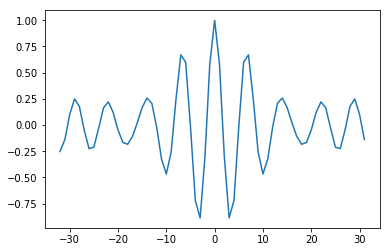

In [10]:
xcorr = Xcorr.sum(axis=1)
xcorr /= xcorr.max()
plt.plot(np.arange(-N_X/2, N_X/2), xcorr)
print('First maximum reached at index ' + str(np.argmax(xcorr)) + ' - that is normal as we plot the autocorrelation')
print('Max = ', xcorr[np.argmax(xcorr)])

To find the period, intuitively, one could just find the zero of the gradient:

First zero gradient reached at index 4 - at the minimum of the xcorr
-0.210252703916 0.435683947279


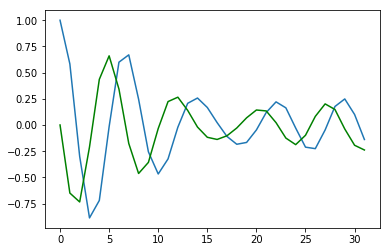

In [11]:
half_xcorr = xcorr[N_X//2:]
half_xcorr_gradient = np.gradient(xcorr)[N_X//2:]
plt.plot(half_xcorr)
plt.plot(half_xcorr_gradient, 'g')
idx = np.argmax(half_xcorr_gradient>0)
print('First zero gradient reached at index ' + str(idx) + ' - at the minimum of the xcorr')
print (half_xcorr_gradient[idx-1], half_xcorr_gradient[idx])

We thus get in pixels half of the width of a period.

More precisely, let's fit with a sinusoid (that's yet another FFT...):

Max auto correlation reached at frequency 9
Max auto correlation reached with a period 7.11111111111


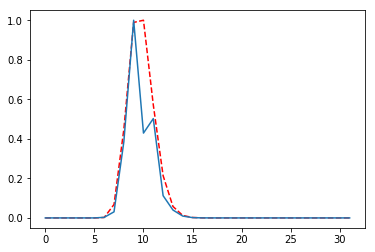

In [12]:
xcorr_MC = np.absolute(mc_i**2).sum(axis=-1).sum(axis=-1)
half_xcorr_MC = xcorr_MC[N_X//2:]
half_xcorr_MC /= half_xcorr_MC.max()
plt.plot(half_xcorr_MC, 'r--')

half_xcorr_FT = np.absolute(np.fft.fft(xcorr))[:N_X//2]
half_xcorr_FT /= half_xcorr_FT.max()
plt.plot(half_xcorr_FT)
idx = np.argmax(half_xcorr_FT)
print('Max auto correlation reached at frequency ' + str(idx))
print('Max auto correlation reached with a period ' + str(1.*N_X/idx))

Wrapping things up:

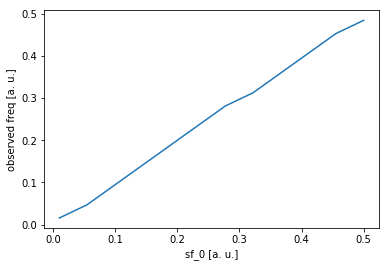

In [13]:
sf_0_ = [0.01, 0.05, 0.1, 0.2, 0.4, 0.8]
sf_0_ = np.linspace(0.01, .5, 12)
downscale = 4
fx, fy, ft = mc.get_grids(mc.N_X//downscale, mc.N_Y//downscale, mc.N_frame//downscale)

def period_px(mc_i):
    N_X, N_Y, N_frame = im.shape
    xcorr_MC = np.absolute(mc_i**2).sum(axis=-1).sum(axis=-1)
    half_xcorr_MC = xcorr_MC[N_X//2:]
    idx = np.argmax(half_xcorr_MC)
    return np.fft.fftfreq(N_X)[idx]

ppx = np.zeros_like(sf_0_)
for i, sf_0 in enumerate(sf_0_):
    mc_i = mc.envelope_gabor(fx, fy, ft, 
                             V_X=0., V_Y=0., 
                             sf_0=sf_0, B_sf=0.03)
    ppx[i] = period_px(mc_i)
    
plt.plot(sf_0_, ppx)
plt.xlabel('sf_0 [a. u.]')
plt.ylabel('observed freq [a. u.]')

Note that the range of frequencies is accessible using:

In [14]:
print(np.fft.fftfreq(fx.shape[0]))

[ 0.       0.01562  0.03125  0.04688  0.0625   0.07812  0.09375  0.10938
  0.125    0.14062  0.15625  0.17188  0.1875   0.20312  0.21875  0.23438
  0.25     0.26562  0.28125  0.29688  0.3125   0.32812  0.34375  0.35938
  0.375    0.39062  0.40625  0.42188  0.4375   0.45312  0.46875  0.48438
 -0.5     -0.48438 -0.46875 -0.45312 -0.4375  -0.42188 -0.40625 -0.39062
 -0.375   -0.35938 -0.34375 -0.32812 -0.3125  -0.29688 -0.28125 -0.26562
 -0.25    -0.23438 -0.21875 -0.20312 -0.1875  -0.17188 -0.15625 -0.14062
 -0.125   -0.10938 -0.09375 -0.07812 -0.0625  -0.04688 -0.03125 -0.01562]
